# OpenMEASURE

[OpenMEASURE](https://github.com/albertoprocacci/OpenMEASURE) is a bunch of pyhton libraries bundled in a pypi [package](https://pypi.org/project/OpenMEASURE/), meaning that it can be easily installed using pip. For now, it contains 4 modules but we will focus on the module for building Reduced-Order Models (ROMs). 

The ROMs are built using Proper Orthogonal Decomposition (POD) and Gaussian Process Regression (GPR). In OpenMEASURE, we use the [GPyTorch](https://gpytorch.ai/) package to build the GPR model. GPyTorch is built on top of [PyTorch](https://pytorch.org/), which is attractive because it allows for GPU accelerations and other cool features (eventually).



## Exercise 1

In the first exercise, we will build a ROM of a simple toy problem. The dataset consists of a 1D manifold in 2D space. First, we use POD to recover the 1D manifold. Then, we use GPR to build the regression model.

In [87]:
# command used to install openmeasure
! pip install -q openmeasure

# you may need to install matplotlib as well
! pip install -q matplotlib

  Attempting uninstall: openmeasure
    Found existing installation: OpenMEASURE 0.2.0
    Uninstalling OpenMEASURE-0.2.0:
      Successfully uninstalled OpenMEASURE-0.2.0


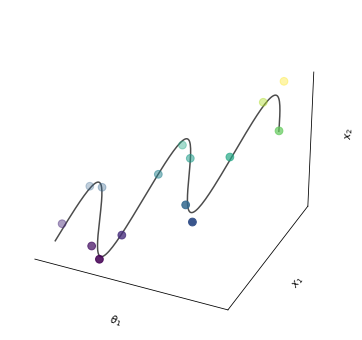

In [236]:
# In this cell we generate the data

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def generate_data(n_samples=15, noise_std=0.1):
    n_plot = 200
    
    theta_s = np.linspace(-5*np.pi, 5*np.pi, n_samples)
    theta_p = np.linspace(-5*np.pi, 5*np.pi, n_plot)

    np.random.seed(3)
    noise = np.random.normal(scale=noise_std, size=n_samples)
    
    f_true = 0.05*theta_p + 0.5*np.cos(0.5*theta_p) 
    f_noise = 0.05*theta_s + 0.5*np.cos(0.5*theta_s) + noise 

    A_true = np.zeros((n_plot, 1))
    A_noise = np.zeros((n_samples, 1))
    
    A_true[:,0] = f_true
    A_noise[:,0] = f_noise
    
    U = np.zeros((2,1))
    U[0,0] = 1
    U[1,0] = 2

    X_true = U @ A_true.T
    X_noise = U @ A_noise.T

    return theta_s, A_noise, X_noise, theta_p, X_true

def plot_3D(x, y, z, x_true, y_true, z_true, a, filename=''):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x, y, z, c=a[:,0], s=60, vmin=a.min(), vmax=a.max())
    ax.plot(x_true, y_true, z_true, c='k', alpha=0.7, zorder=0)

    ax.set_xlabel(r'$\theta_1$')
    ax.set_ylabel(r'$x_1$')
    ax.set_zlabel(r'$x_2$')

    # Hide grid lines
    ax.grid(False)

    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    ax.view_init(elev=30, azim=-65)
    
    if filename != '':
        fig.savefig(filename, transparent=False, dpi=600, bbox_inches='tight')

# This function compute the indipendent variable (theta), the low-dim (A) and high-dim (X) dependent variables
# theta_p, X_true are used to show the true function
theta, A, X, theta_p, X_true = generate_data()

plot_3D(theta, X[0, :], X[1, :], theta_p, X_true[0, :], X_true[1, :], A)

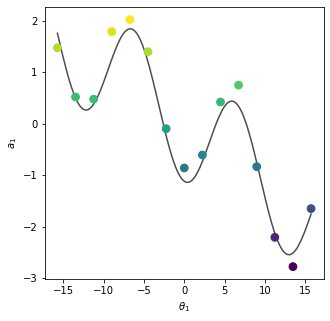

In [237]:
# In this cell, we apply POD

from gpr import GPR

def plot_2D(x, y, x_true, y_true, filename=''):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()
    ax.scatter(x, y, c=y, s=60)
    ax.plot(x_true, y_true, c='k', alpha=0.7, zorder=0)

    ax.set_xlabel(r'$\theta_1$')
    ax.set_ylabel(r'$a_1$')
    
    # ax.set_ylim(-2.5, 2.5)
    
    # Hide grid lines
    ax.grid(False)

    # Hide axes ticks
    # ax.set_xticks([])
    # ax.set_yticks([])
    
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)

    if filename != '':
        fig.savefig(filename, transparent=False, dpi=600, bbox_inches='tight')

xyz = np.zeros((theta.size, 3))
P = np.zeros((theta.size, 1))
P[:,0] = theta

# Create the gpr object
rom = GPR(X, 1, xyz, P)

X0 = rom.scale_data(scale_type='none')
U, A, exp_var = rom.decomposition(X0, select_modes='number', n_modes=1)

A_true = np.transpose(U.T @ X_true)
plot_2D(theta, A[:,0], theta_p, A_true[:,0])



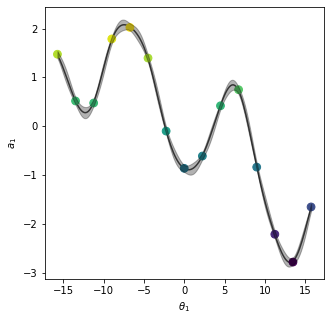

In [238]:
# In this cell we build the GPR model with default options

import torch
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood, GaussianLikelihood
from gpytorch.kernels import ScaleKernel, LinearKernel, RBFKernel

def plot_prediction(x, y, x_pred, y_pred, y_sigma, filename=''):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()
    ax.scatter(x, y, c=y, s=60)
    ax.plot(x_pred, y_pred, c='k', alpha=0.7, zorder=0)
    ax.fill_between(x_pred, y_pred+y_sigma, y_pred-y_sigma, color='k', alpha=0.3)

    ax.set_xlabel(r'$\theta_1$')
    ax.set_ylabel(r'$a_1$')
    
    # ax.set_ylim(-2.5, 2.5)
    
    # Hide grid lines
    ax.grid(False)

    # Hide axes ticks
    # ax.set_xticks([])
    # ax.set_yticks([])
    
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)

    if filename != '':
        fig.savefig(filename, transparent=False, dpi=600, bbox_inches='tight')

gpr = GPR(X, 1, xyz, P) # create the gpr object 

# fit the model
models, likelihoods = gpr.fit(scaleX_type='none', scaleP_type='none', select_modes='number', 
                              n_modes=1, verbose=False, lr=0.1)

# predict the results
P_true = (np.zeros((theta_p.size,1)))
P_true[:, 0] = theta_p
Ap, Sigmap = gpr.predict(P_true)

plot_prediction(theta, A[:,0], theta_p, Ap[:,0], Sigmap[:,0])


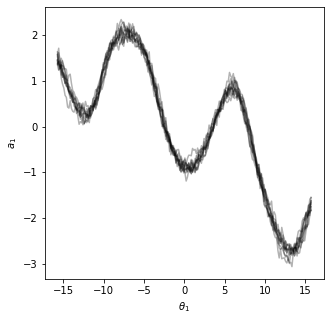

In [243]:
# In this cell we generate multiple samples from the posterior

def plot_samples(x, Y_samples, filename=''):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()
    for i in range(Y_samples.shape[0]):
        ax.plot(x, Y_samples[i,:], c='k', alpha=0.3, zorder=0)
    
    ax.set_xlabel(r'$\theta_1$')
    ax.set_ylabel(r'$a_1$')
    
    # ax.set_ylim(-2.5, 2.5)
    
    # Hide grid lines
    ax.grid(False)

    # Hide axes ticks
    # ax.set_xticks([])
    # ax.set_yticks([])
    
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)

    if filename != '':
        fig.savefig(filename, transparent=False, dpi=600, bbox_inches='tight')

models[0].eval()
likelihoods[0].eval()
posterior = likelihoods[0](models[0](torch.from_numpy(P_true)))
samples = gpr.Sigma_r * posterior.sample(sample_shape=torch.Size([10])).numpy()

plot_samples(theta_p, samples)

/opt/anaconda3/envs/env_ml2/lib/python3.9/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
/opt/anaconda3/envs/env_ml2/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


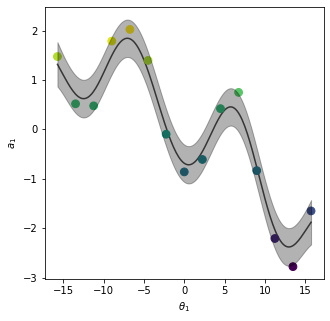

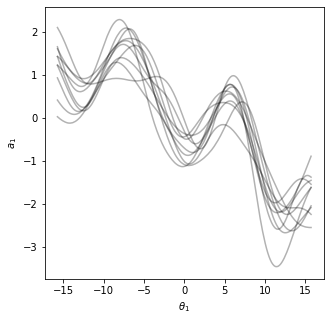

In [249]:
# In this cell we change the likelihood and the kernel

noise = 1e-2*torch.ones(P.shape[0])
likelihood = FixedNoiseGaussianLikelihood(noise=noise)
kernel = ScaleKernel(LinearKernel() + RBFKernel())
gpr = GPR(X, 1, xyz, P, likelihood=likelihood, kernel=kernel)

# fit the model
models, likelihoods = gpr.fit(scaleX_type='none', scaleP_type='none', 
                              select_modes='number', n_modes=1, verbose=False, lr=0.1)

# predict the results
P_true = (np.zeros((theta_p.size,1)))
P_true[:, 0] = theta_p
Ap, Sigmap = gpr.predict(P_true)

plot_prediction(theta, A[:,0], theta_p, Ap[:,0], Sigmap[:,0])

models[0].eval()
likelihoods[0].eval()
posterior = likelihoods[0](models[0](torch.from_numpy(P_true)))
samples = gpr.Sigma_r * posterior.sample(sample_shape=torch.Size([10])).numpy()

plot_samples(theta_p, samples)

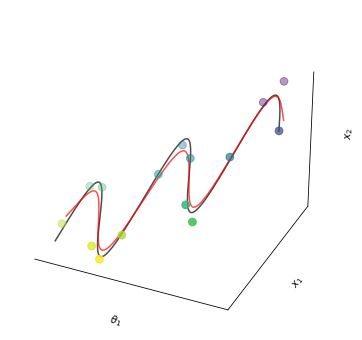

In [250]:
# Reconstruct in the original dimension

def plot_prediction_3D(x, y, z, x_true, y_true, z_true, y_pred, z_pred, a, filename=''):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x, y, z, c=a[:,0], s=60, vmin=a.min(), vmax=a.max())
    ax.plot(x_true, y_true, z_true, c='k', alpha=0.7, zorder=0)
    ax.plot(x_true, y_pred, z_pred, c='r', alpha=0.7, zorder=0)

    ax.set_xlabel(r'$\theta_1$')
    ax.set_ylabel(r'$x_1$')
    ax.set_zlabel(r'$x_2$')

    # Hide grid lines
    ax.grid(False)

    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    ax.view_init(elev=30, azim=-65)
    
    if filename != '':
        fig.savefig(filename, transparent=False, dpi=600, bbox_inches='tight')

Xp = gpr.reconstruct(Ap)
plot_prediction_3D(theta, X[0, :], X[1, :], theta_p, X_true[0, :], X_true[1, :], Xp[0, :], Xp[1, :], A)